In [9]:
import numpy as np
from matplotlib import pyplot as plt
from otimo import QuasiNewton, SecaoAurea, Gradiente, GradienteConjugado
from otimo import Solution, HookeJeeves, NelderMeadSimplex

# Métodos Sem Derivadas

## Problemas dos métodos de direção de busca em funções não-diferenciáveis

\begin{align}
    \min\limits_{\mathbf{x}} f(\mathbf{x}) &= \max(f_1, f_2, f_3) \\
    f_1 &= x_1^2 + x_2^4 \\
    f_2 &= (2-x_1)^2 + (2-x_2)^2 \\
    f_3 &= 2e^{x_2-x_1}
\end{align}

Charalambous, C., & Conn, A. R. (1978). An efficient method to solve the minimax problem directly. *SIAM Journal on Numerical Analysis*, 15(1), 162-187.

Solução ótima: [1.04551895 0.96886624]
Número de iterações: 441
Número de avaliações: 5005


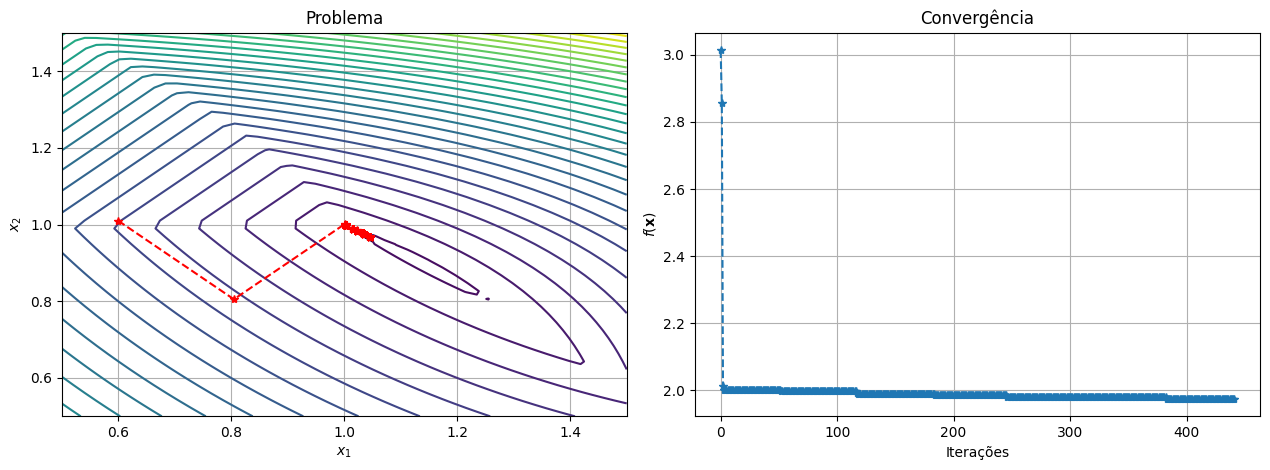

In [10]:
# Definição da função objetivo
def func(x):
    x1, x2 = x[0], x[1]
    
    f1 = x1**2 + x2**4
    f2 = (2-x1)**2 + (2-x2)**2
    f3 = 2*np.exp(x2-x1)
    
    return max([f1, f2, f3])

# Ponto inicial
x0 = [.6, 1.01]

# Execução do Método do Gradiente
solucao = Gradiente(SecaoAurea(precisao=1e-2, passo=1e-12, maxaval=100),
                    maxit=1000, maxaval=5000, precisao=1e-5).resolva(func, x0)

print(solucao)
solucao.resultados(func, [.5, 1.5], [.5, 1.5])

## Hooke-Jeeves

Solução ótima: [1.08025316 0.944     ]
Número de iterações: 16000
Número de avaliações: 80003


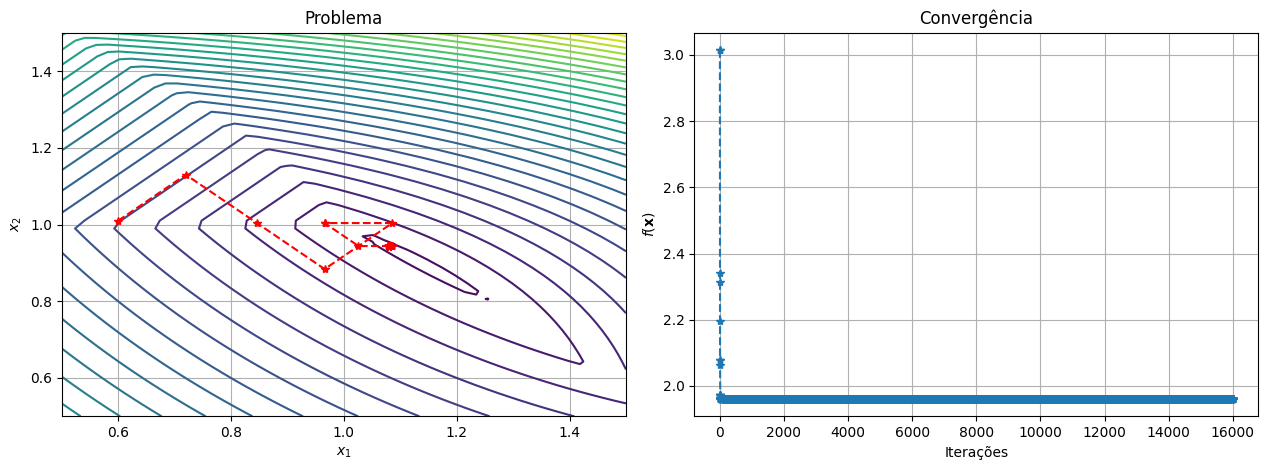

In [11]:
# Inicializa variáveis
x = np.array(x0)
fx = func(x)
xhist = [x0.copy()]
fxhist = [fx]

# Parâmetros do algoritmo
lamb = 1.2e-1 # Passo em uma direção na fase de exploração
alpha = 1e-1
max_iter = 16000
avaliacoes = 0

# Número de variáveis
N = x.size

for _ in range(max_iter):
        
    """ Busca em cada coordenada """
    y = np.copy(x)
    xt = np.copy(x)
    for n in range(N):
        
        # Dou um passo em um eixo
        xt[n] = x[n] + lamb
        fxt = func(xt)
        avaliacoes += 1
        
        # Se eu melhorei dando esse passo
        if fxt < fx:
            y[n] = xt[n]
            continue # Salvo esse passo e vou para próxima variável
        
        # Se eu tiver piorado, dou um passo no sentido contrário
        xt[n] = x[n] - lamb
        fxt = func(xt)
        avaliacoes += 1
        
        # Se eu melhorei dando esse passo
        if fxt < fx:
            y[n] = xt[n]
            continue # Salvo esse passo e vou para próxima variável
        
        # Caso contrário, eu fico com o mesmo valor
        y[n] = x[n]

    """ Busca na direção """
    fy = func(y)
    avaliacoes += 1
    
    # Se minha busca por coordenada retornou uma solução melhor
    if fy < fx:
        
        # Tento dar um passo na direção final que eu andei
        z = y + alpha*(y-x)
        fz = func(z)
        avaliacoes += 1
        
        # Caso esse passo seja melhor, atualiza 
        if fz < fy:
            x = z
            fx = fz
        
        # Fica com o anterior e diminui o passo nessa direção
        else:
            x = y
            fx = fy
            alpha = alpha/2
    
    # Reduz o passo em cada coordenada
    else:
        lamb = lamb/2
        
    xhist.append(x.copy())
    fxhist.append(fx)

# Exibe resultados
solucao = Solution(x=x, fx=fx, iter=max_iter, aval=avaliacoes,
                   xhist=np.array(xhist), fxhist=np.array(fxhist))
print(solucao)
solucao.resultados(func, [.5, 1.5], [.5, 1.5])

## Método Nelder-Meader Simplex

Reflexão
Contração
Reflexão
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Encolhimento
Resultado: [1.04684634 0.96791788]
Valor da função: 1.9736954097543025
Avaliações: 87
Iterações: 18


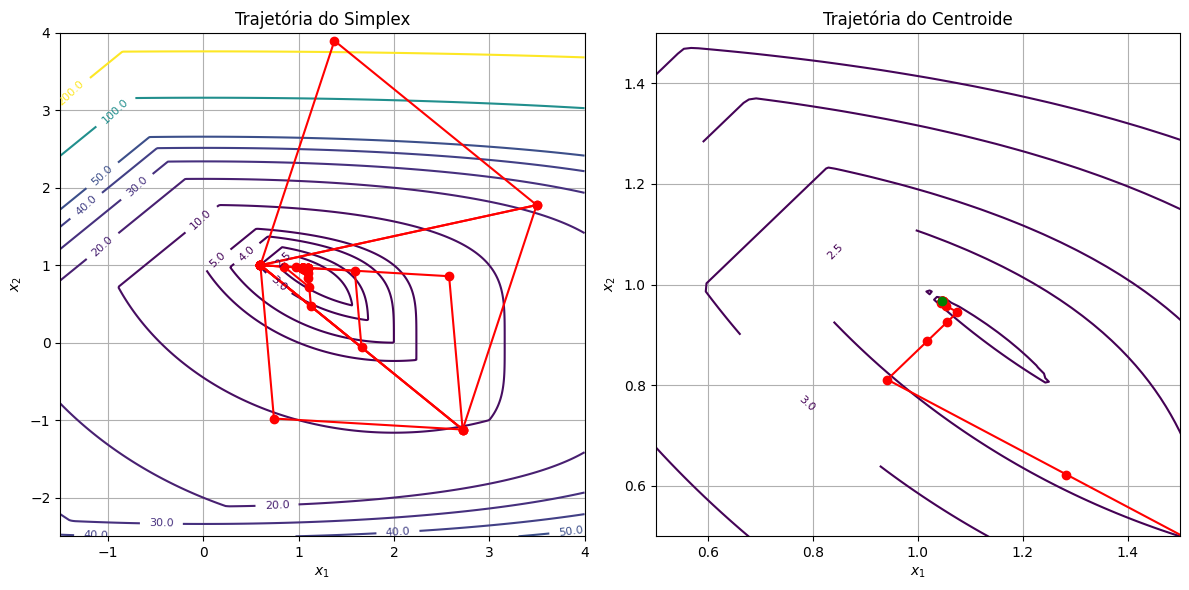

In [12]:
# Parâmetros Iniciais
ponto_inicial = [0.6, 1.0]
ponto_inicial = np.array(ponto_inicial)
tol = 1e-4
max_iter = 500
    
# Variáveis do método
num_variaveis = ponto_inicial.size
num_pontos = num_variaveis + 1
alpha = 1.0 # Coeficiente de reflexão
gamma = 2.0 # Coeficiente de expansão
beta = 0.5 # Coeficiente de contração

# Metodologia de inicialização do simplex conforme seguinte referência:
# Spendley, W. G. R. F. R., George R. Hext, and Francis R. Himsworth. 
# "Sequential application of simplex designs in optimisation and evolutionary 
# operation." Technometrics 4.4 (1962): 441-461.
simplex_inicial = [ponto_inicial]
a = num_pontos
n = num_variaveis
p = a/(n*np.sqrt(2))*(np.sqrt(n+1) + n - 1)
q = a/(n*np.sqrt(2))*(np.sqrt(n+1) - 1)
u = np.eye(n)
for i in range(num_variaveis):
    ponto = ponto_inicial.copy()
    ponto += p*u[i, :]
    for j in range(n):
        if j != i:
            ponto += q*u[j, :]
    simplex_inicial.append(ponto)

# Inicialização do simplex
simplex = np.array(simplex_inicial)
valores = [func(ponto) for ponto in simplex]
iteracao = 0
avaliacoes = 3

# Registro da história do simplex
xhist = [np.mean(simplex, axis=0)]
fxhist = [valores[0]]
simplexhist = [simplex.copy()]


# Critério de parada: número de iterações ou a diferença dos pontos do simplex
# ser pequena demais
while iteracao < max_iter and np.max(np.abs(simplex[1:] - simplex[0])) > tol:

    # Ordenar o simplex: o primeiro ponto é o melhor e o último é o pior
    ordem = np.argsort(valores)
    simplex = simplex[ordem]
    valores = [func(ponto) for ponto in simplex]
    avaliacoes += 3

    # Nomes dos pontos
    xb, fb = simplex[0], valores[0] # Melhor ponto
    xs, fs = simplex[-2], valores[-2] # Segundo pior ponto
    xw, fw = simplex[-1], valores[-1] # Pior ponto

    # Calcular o centro do simplex, excluindo o pior ponto
    centroide = np.mean(simplex[:-1], axis=0)
    xh = centroide # Um nome mais curto para o centróide

    # Primeira tentativa: reflexão
    xr = xh + alpha*(xh - xw)
    fr = func(xr)

    # Caso a reflexão seja melhor que o melhor ponto do simplex
    if fr < fb:

        # Segunda tentativa: expansão
        xe = xh + gamma*(xr - xh)
        fe = func(xe)

        # Se a expansão for melhor ainda que a reflexão, fica com a expansão
        if fe < fr:
            simplex[-1] = xe
            valores[-1] = fe
            print('Expansão')
        
        # Se a expansão não for melhor que a reflexão, fica com a reflexão
        else:
            simplex[-1] = xr
            valores[-1] = fr
            print('Reflexão')

    # Caso a reflexão não seja melhor que o melhor ponto do simplex,
    # mas seja pelo menos melhor que o segundo pior ponto
    elif fb <= fr < fs:

        # Fica com a reflexão
        simplex[-1] = xr
        valores[-1] = fr
        print('Reflexão')

    # Caso a reflexão seja pior que o segundo pior ponto, mas melhor que o pior 
    # ponto
    elif fs <= fr < fw:
            
        # Terceira tentativa: contração
        xc = xh + beta*(xr - xh)
        fc = func(xc)
    
        # Se a contração for melhor que o ponto da reflexão, substitui o pior
        # ponto pelo ponto da contração
        if fc < fr:
            simplex[-1] = xc
            valores[-1] = fc
            print('Contração')

        # Se a contração não for melhor que o ponto da reflexão, substitui o
        # pior ponto pelo ponto da reflexão
        else:
            simplex[-1] = xr
            valores[-1] = fr
            print('Reflexão')

    # Caso a reflexão seja pior que o pior ponto
    else:

        # Encolhimento do simplex
        for i in range(1, num_pontos):
            simplex[i] = (simplex[i] + xb)/2
            valores[i] = func(simplex[i])
            avaliacoes += 1
        print('Encolhimento')
 
    # Registros
    iteracao += 1
    xhist.append(np.mean(simplex, axis=0))
    fxhist.append(valores[0])
    simplexhist.append(simplex.copy())

# Solução final é o melhor ponto do simplex final
x = simplex[0]
fx = func(simplex[0])

# Exibe resultados
print(f"Resultado: {x}")
print(f"Valor da função: {fx}")
print(f"Avaliações: {avaliacoes}")
print(f"Iterações: {iteracao}")

# Conversão para numpy array
simplexhist = np.array(simplexhist)
xhist = np.array(xhist)
fxhist = np.array(fxhist)

# Malha para plotar contorno
x1, x2 = np.meshgrid(np.linspace(-1.5, 4, 400),
                     np.linspace(-2.5, 4, 400))

# Avalia função para plotar contorno
f = np.zeros(x1.shape)
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        f[i, j] = func([x1[i, j], x2[i, j]])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Primeira figura: trajetória do simplex
contour1 = axs[0].contour(x1, x2, f, levels=[2.5, 3, 4, 5, 10, 20, 30, 40, 50,
                                             100, 200])
axs[0].clabel(contour1, inline=True, fontsize=8)
for n in range(simplexhist.shape[0]):
    axs[0].plot(simplexhist[n, :, 0].tolist() + [simplexhist[n, 0, 0]],
                simplexhist[n, :, 1].tolist() + [simplexhist[n, 0, 1]], '-or')
axs[0].set_xlabel(r'$x_1$')
axs[0].set_ylabel(r'$x_2$')
axs[0].set_title('Trajetória do Simplex')
axs[0].grid()

# Segunda figura: trajetória do ponto médio do simplex
contour2 = axs[1].contour(x1, x2, f, levels=[2., 2.5, 3, 4, 5, 10, 20, 30, 40, 50,
                                             100, 200])
axs[1].clabel(contour2, inline=True, fontsize=8)
axs[1].plot(xhist[:, 0], xhist[:, 1], '-or')
axs[1].plot(x[0], x[1], 'og')
axs[1].set_xlabel(r'$x_1$')
axs[1].set_ylabel(r'$x_2$')
axs[1].set_title('Trajetória do Centroide')
axs[1].set_xlim(.5, 1.5)
axs[1].set_ylim(.5, 1.5)
axs[1].grid()

plt.tight_layout()
plt.show()

## Outras funções-objetivo

\begin{align}
    \min\limits_{\mathbf{x}} f(\mathbf{x}) &= \max(f_1, f_2) \\
    f_1 &= x_1^2 + (x_2-1)^2 + x_2 - 1 \\
    f_2 &= -x_1^2 - (x_2-1)^2 + x_2 +1
\end{align}

Solução ótima: [0.25    0.03125]
Número de iterações: 13
Número de avaliações: 70


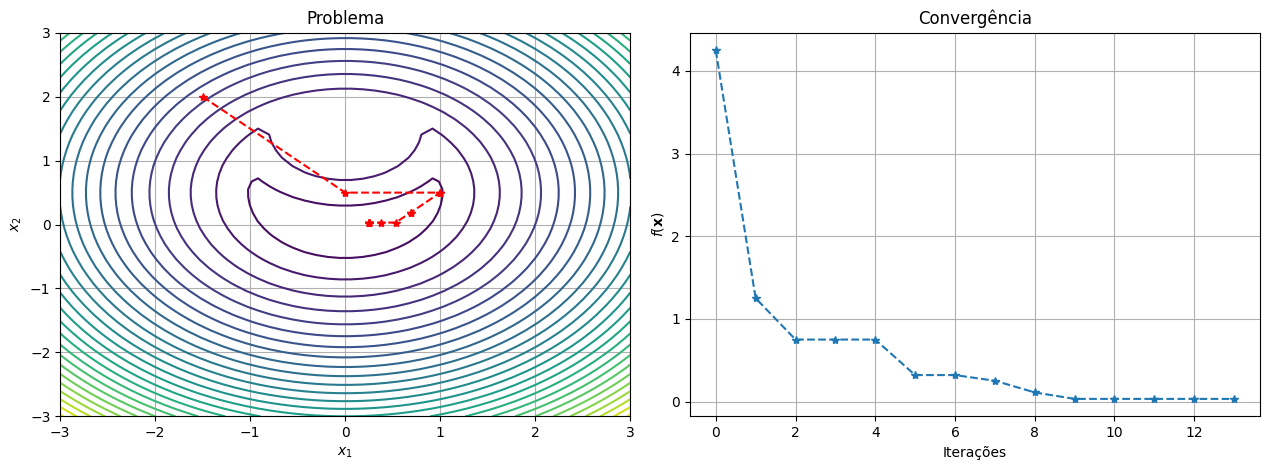

In [13]:
# Definição da função objetivo
def func(x):
    x1, x2 = x[0], x[1]
    
    f1 = x1**2 + (x2-1)**2 + x2 - 1
    f2 = -x1**2 - (x2-1)**2 + x2 +1    
    return max([f1, f2])

# Ponto inicial
x0 = [-1.5, 2.]

# Execução do Método do Gradiente
solucao = HookeJeeves(passo_coordenada=1., passo_direcao=.5, maxit=1000,
                      maxaval=5000, precisao=1e-5).resolva(func, x0)

print(solucao)
solucao.resultados(func, [-3,  3], [-3, 3])

\begin{align}
    \min\limits_{\mathbf{x}} f(\mathbf{x}) &= \max(f_1, f_2, f_3) \\
    f_1 &= x_1^2 + x_2^4 \\
    f_2 &= (2-x_1)^2 + (2-x_2)^2 \\
    f_3 &= 2e^{-x_1+x_2}
\end{align}

Solução ótima: [2. 2.]
Número de iterações: 32
Número de avaliações: 80


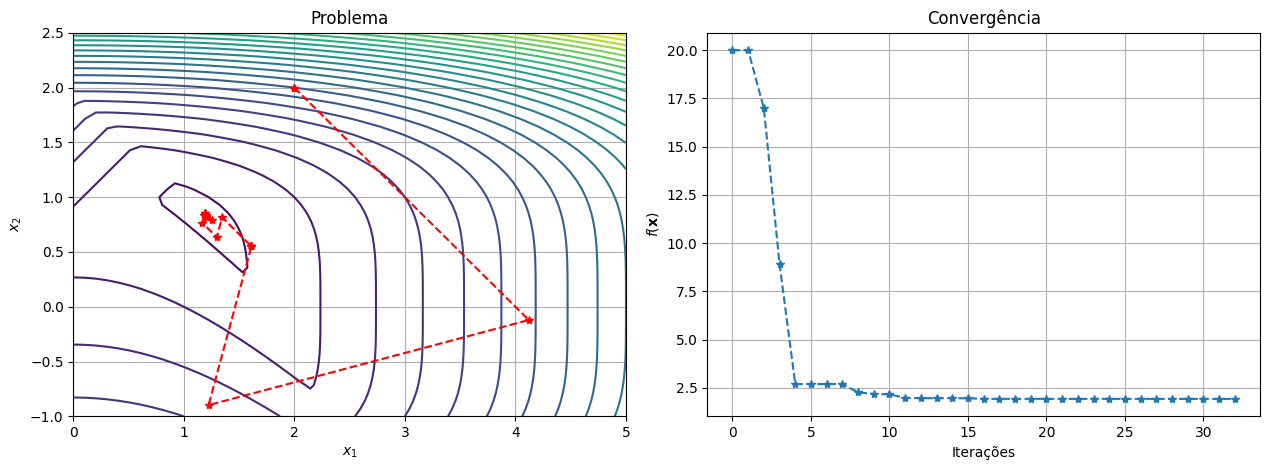

In [14]:
# Definição da função objetivo
def func(x):
    x1, x2 = x[0], x[1]
    
    f1 = x1**2 + x2**4
    f2 = (2-x1**2) + (2-x2)**2
    f3 = 2*np.exp(-x1 + x2)
    return max([f1, f2, f3])

# Ponto inicial
x0 = [2, 2]

# Execução do Método do Gradiente
solucao = NelderMeadSimplex(maxit=1000, maxaval=5000,
                            precisao=1e-5).resolva(func, x0)

print(solucao)
solucao.resultados(func, [0,  5], [-1, 2.5])

Solução ótima: [-120.56188654 -120.56188654]
Número de iterações: 2
Número de avaliações: 61


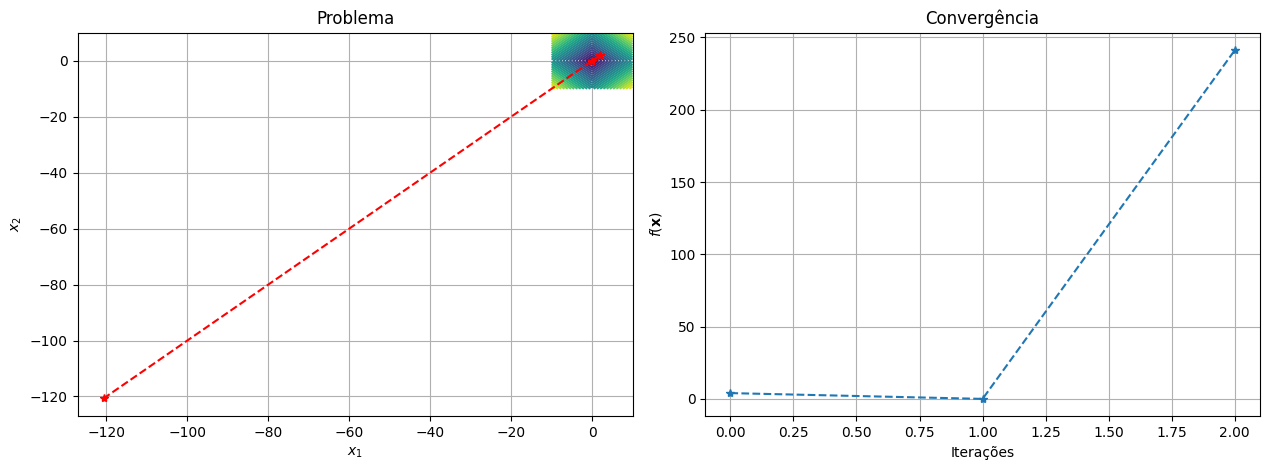

In [15]:
# Definição da função objetivo
def func(x):
    x1, x2 = x[0], x[1]
    return abs(x1) + abs(x2)

# Ponto inicial
x0 = [2, 2]

# Execução do Método do Gradiente
# solucao = Gradiente(SecaoAurea(precisao=1e-2, passo=1e-12, maxaval=100),
#                     maxit=1000, maxaval=5000, precisao=1e-5).resolva(func, x0)
solucao = QuasiNewton(SecaoAurea(precisao=1e-3, passo=1e-5, maxaval=100),
                    maxit=2, maxaval=5000, precisao=1e-5).resolva(func, x0)

print(solucao)
solucao.resultados(func, [-10., 10.], [-10., 10.])